## Modelo Deep Learning
 Eric Manuel Navarro Martínez A01746219

El problema que solucionará el modelo elegido será el de clasificación de tumores, siguiendo el orden de las clases provisto por el mismo. Este dataset contiene tumores: pituitarios, benignos, gliomas y meningiomas; si podemos clasificar de manera adecuada el tipo de tumor, no solo estamos salvando la vida de los pacientes que padezcan, sino que también podemos darles las herramientas e información que necesiten ya que cada tipo de tumor tiene tazas distintas de supervivencia, y la detección pronta y adecuada permite que alarguemos la vida de los pacientes.
El origen del dataset es: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans/data
no puede ser incluido en el repositorio ya que pesa demasiado

Para comenzar definiremos todas las bibliotecas que van a ser necesarias para la creación del modelo al igual que la creación de graficas que nos permitan visualizar nuestro modelo y sus resultados. 

In [69]:
import numpy as np
import pandas as pd
import os, shutil, pathlib, random
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


Nuestro dataset inicial viene dividido en las clases previamente mencionadas, por lo que vamos a crear folders donde podamos tener una separación adecuada para entrenar, validar y probar el modelo,  por lo que lo dividiremos de tal forma que tengamos 70% para training, 15% para validation y 15% para testing.

In [ ]:
# Define las rutas y clases
base_dir = Path("brain_tumors")
output_dir = Path("Dataset")  # Carpeta de salida
classes = ['glioma', 'healthy', 'meningioma', 'pituitary']

# Define la proporción de división
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Crear las carpetas de destino si no existen
for split in ["train", "validation", "test"]:
    for class_name in classes:
        (output_dir / split / class_name).mkdir(parents=True, exist_ok=True)

# Recorre cada clase y divide las imágenes
for class_name in classes:
    class_path = base_dir / class_name
    images = list(class_path.glob("*"))  # Lista de todas las imágenes en la clase
    random.shuffle(images)  # Baraja las imágenes aleatoriamente
    
    # Calcula las cantidades para cada conjunto
    train_count = int(len(images) * train_ratio)
    val_count = int(len(images) * val_ratio)
    
    # Asigna las imágenes a cada conjunto
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]
    
    # Mueve las imágenes a las carpetas correspondientes
    for image_path in train_images:
        shutil.move(str(image_path), str(output_dir / "train" / class_name / image_path.name))
    for image_path in val_images:
        shutil.move(str(image_path), str(output_dir / "validation" / class_name / image_path.name))
    for image_path in test_images:
        shutil.move(str(image_path), str(output_dir / "test" / class_name / image_path.name))

print("Imágenes divididas en conjuntos de entrenamiento, validación y prueba.")


Imágenes divididas en conjuntos de entrenamiento, validación y prueba.


Una vez divido, podemos crear datasets apartir de los folders con las imagenes ya divididas, creando clases de cada uno.

In [ ]:
base_dir = pathlib.Path("Dataset")

#Crear datasets de entrenamiento, validación y prueba
train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180, 180), #No usamos 520 x520 en imagenes ya que requeriría más memoria y causaría un entrenamiento más largo
    batch_size=32, 
    label_mode="int", #Usamos "int" para que las etiquetas sean números enteros ya que no requerimos one-hot encoding
)

validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(180, 180),
    batch_size=32,
    label_mode="int",
)

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180, 180),
    batch_size=32,
    label_mode="int",
)

Found 4914 files belonging to 4 classes.
Found 1052 files belonging to 4 classes.
Found 1057 files belonging to 4 classes.


Vamos a cersiorarnos que nuestro dataset haya creado las clases correctas, por lo que vamos a crear un grafico con alguna cantidad de imagenes, mostrando la etiqueta que tiene dicho elemento.

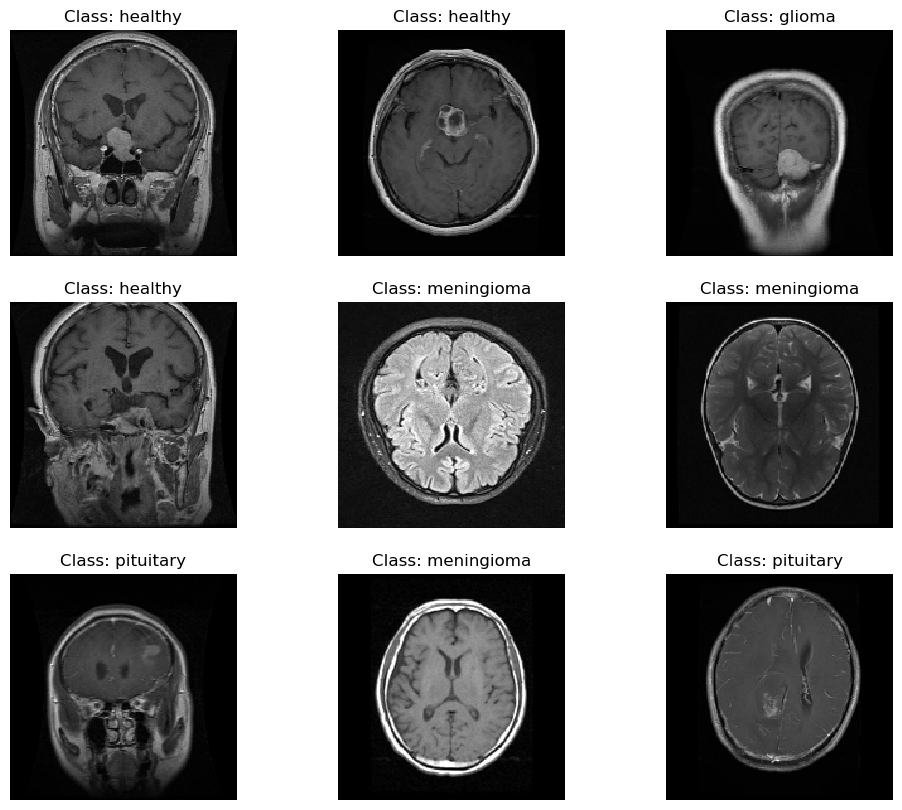

In [32]:
classes = ['pituitary', 'meningioma', 'glioma', 'healthy']
plt.figure(figsize=(12, 10))
index = 0
for element in train_dataset.take(1):
  for i in range(9):
    image = element[0][i]
    label = element[1][i]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image/255, interpolation="nearest")
    plt.title("Class: {}".format(classes[label]))
    plt.axis("off")

plt.show()

Podemos entonces iniciar con la creación de nuestro modelo, que nos permita ser lo más certeros posibles, por lo que agregamos distintas capas tanto de convolución como densas, creando el flatten y el max pooling

In [40]:
model2 = Sequential([
    Input(shape=(180,180,3)),
    Conv2D(16, kernel_size=3, padding='same', activation="relu"),
    MaxPooling2D(2),
    Conv2D(32, kernel_size=3, padding='same', activation="relu"),
    MaxPooling2D(2),
    Flatten(),
    Dense(10, activation='softmax')
])

Por el tipo de problema compilaremos usando "sparse_categorical_crossentropy", ya que tenemos 4 clases, con la metrica de accuracy para saber como va el entrenamiento del modelo.

In [41]:
model2.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Para empezar a entrenar agregaremos el callback de Checkpoint que nos va a permitir guardar el modelo que tenga las mejores 
Por ultimo elegimos 100 epocas para entrenar nuestro modelo

In [42]:
from keras.callbacks import ModelCheckpoint

train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath="resnet_dsc.keras", save_best_only=True, monitor="val_loss")]

# Entrenar el modelo
history = model2.fit(
    train_dataset, 
    epochs=100,
    validation_data=validation_dataset, 
    callbacks=callbacks
)


Epoch 1/100


154/154 [==============================] - 46s 294ms/step - loss: 15.8512 - accuracy: 0.7591 - val_loss: 0.4791 - val_accuracy: 0.8489
Epoch 2/100
154/154 [==============================] - 35s 228ms/step - loss: 0.2778 - accuracy: 0.9219 - val_loss: 0.4502 - val_accuracy: 0.8878
Epoch 3/100
154/154 [==============================] - 36s 235ms/step - loss: 0.2699 - accuracy: 0.9552 - val_loss: 0.5110 - val_accuracy: 0.9106
Epoch 4/100
154/154 [==============================] - 34s 222ms/step - loss: 0.1210 - accuracy: 0.9742 - val_loss: 0.5014 - val_accuracy: 0.9211
Epoch 5/100
154/154 [==============================] - 33s 214ms/step - loss: 0.1297 - accuracy: 0.9737 - val_loss: 0.5957 - val_accuracy: 0.9173
Epoch 6/100
154/154 [==============================] - 35s 228ms/step - loss: 0.1083 - accuracy: 0.9819 - val_loss: 0.7946 - val_accuracy: 0.9211
Epoch 7/100
154/154 [==============================] - 33s 216ms/step - loss: 0.0809 - accuracy: 0.9843 - val_loss: 1.0718 - val_accura

Los resultados del entrenamiento nos muestran varios problemas, entre ello podemos ver un underfit fuerte ya que el accuracy es sumamente alto y el val_loss, crece hasta 6.8053, por lo que en este punto podemos notar que el modelo es malo para predecir.

Por lo que vamos a visualizar para ver si nuestro analisis previo contiene algun error.

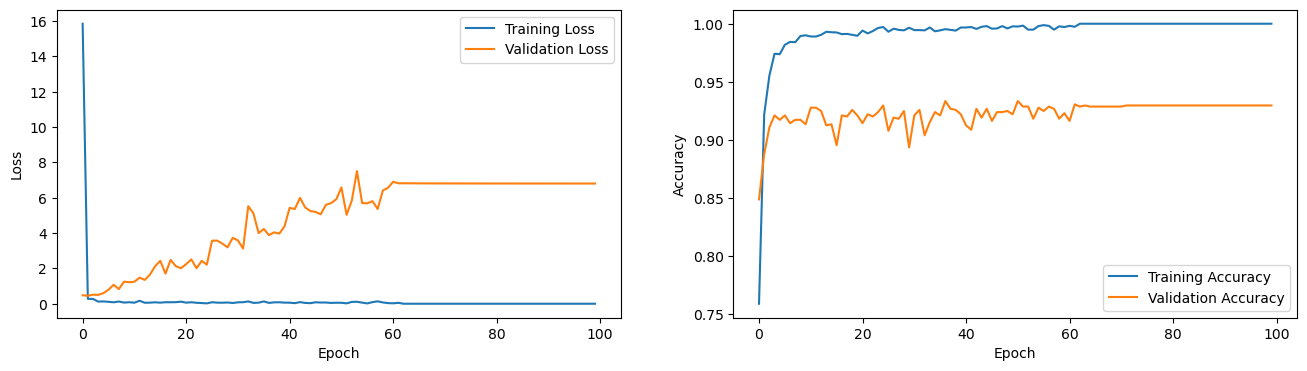

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
    
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Aqui notamos que el modelo se underfitteo ya que en el lado derecho vemos que el accuracy está separado del accuracy de entrenamiento, siguiendo un patrón para nada adecuado.
Por otra parte vemos que la perdida al momento de validar no sigue un patrón que baja, al contrario sube y se estabiliza alrededor de 6 puntos.

In [50]:
model2.evaluate(test_dataset)

34/34 [==============================] - 4s 100ms/step - loss: 4.6218 - accuracy: 0.9376


[4.6218037605285645, 0.9375591278076172]

In [54]:
model2.save("Modelo_sin_mejoras.keras")

Aqui revisamos el modelo y sus resultados, donde podemos ver una perdida sumamente alta, y un accuracy del 93%, pero después del analisis previo determinamos que este accuracy está cesgado por un underfitting.

Aqui es entonces donde mejoraremos el modelo, comenzaremos por modificar y personalizar nuestra capa de redes neuronales, permitiendo multiples cambios que no existen en la clase base.
La lista main_layers contiene las capas principales de la unidad residual, las cuales son dos capas de SeparableConv y BatchNormalization (convolución separable y normalización por lotes) y la función de activación especificada.
Igualmente modificamos la lista de salto de capas para que si los pasos son mayores a 1 esta añada capas adicionales que ajusten el tamaño de la entrada.

In [ ]:
class ResidualUnit(tf.keras.layers.Layer): # Extend base Layer class
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs) # Call Layer's init
        self.activation = tf.keras.activations.get(activation) # Get activation layer
        self.main_layers = [
            tf.keras.layers.SeparableConv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            tf.keras.layers.SeparableConv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1: # Resize input if needed
            self.skip_layers = [
                tf.keras.layers.SeparableConv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                tf.keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

Para iniciar con las mejoras que le realizamos al modelo previo, esta vez realizaremos escalamiento y data augmentation, al igual de una mayor cantidad de capas, combinando convolucionales con normalización por lotes usando un relu para la activación y un Max Pooling.
Y usando los cambios previos podemos usar de mejor manera los filtros.

Para compilar el modelo, tenemos metricas similares, solo cambiamos el optimizador para que tenga una mejor tasa de aprendizaje para cada parámetro.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(180, 180, 3)))

#Data augmentation y Escalamiento
model.add(tf.keras.layers.RandomFlip("horizontal"))
model.add(tf.keras.layers.RandomRotation(0.1))
model.add(tf.keras.layers.RandomZoom(0.2))
model.add(tf.keras.layers.Rescaling(1./255))

#Creamos una Resnet con capas de convolución, seguida de una de normalización por lotes y 
#y una capa de Max pooling para reducir el tamaño de la imagen
model.add(tf.keras.layers.Conv2D(64, 7, strides=2,
                              padding="same", use_bias=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64

# Añadimos varias capas residuales, con los filtros y pasos que sean ajustados por cada capa residual
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(tf.keras.layers.GlobalAvgPool2D())

#Capa de Dropout
model.add(tf.keras.layers.Dropout(0.5))

#Añadimos una capa densa y con activación softmax
model.add(tf.keras.layers.Dense(4, activation="softmax"))

In [27]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

>Para optimizar el entrenamiento y que no tarde tanto tiempo agregamos los siguientes callbacks
>
>> EarlyStopping: Con una paciencia de 10, ya que notaba que con una paciencia más baja el modelo no aprendia lo suficiente y terminaba demasiado pronto.
>
>> ReduceLROnPlateau: Divide a la mitad el learning rate si no mejora, evitando que el entrenamiento sea demasiado lento. 
>
>>ModelCheckpoint: Para realizar los entrenamientos en horarios distintos sin perder el entrenamiento.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Definir los callbacks
callbacks = [
    ModelCheckpoint(
        filepath="resnet_dsc.keras", save_best_only=True, monitor="val_loss"
    ),
    EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    ),  # Detiene si no hay mejora en 10 épocas
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6
    ),  # Reduce el LR a la mitad si no mejora en 5 épocas
]

# Ajuste de datos en paralelo para entrenamiento más rápido
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Entrenar el modelo
history = model.fit(
    train_dataset, 
    epochs=100,
    validation_data=validation_dataset, 
    callbacks=callbacks
)


Epoch 1/100
154/154 [==============================] - 226s 1s/step - loss: 1.1527 - accuracy: 0.5885 - val_loss: 1.4728 - val_accuracy: 0.2310 - lr: 0.0010
Epoch 2/100
154/154 [==============================] - 228s 1s/step - loss: 0.7736 - accuracy: 0.7135 - val_loss: 1.8510 - val_accuracy: 0.2310 - lr: 0.0010
Epoch 3/100
154/154 [==============================] - 188s 1s/step - loss: 0.6092 - accuracy: 0.7827 - val_loss: 1.8279 - val_accuracy: 0.3631 - lr: 0.0010
Epoch 4/100
154/154 [==============================] - 187s 1s/step - loss: 0.4784 - accuracy: 0.8264 - val_loss: 2.6881 - val_accuracy: 0.6949 - lr: 0.0010
Epoch 5/100
154/154 [==============================] - 208s 1s/step - loss: 0.3940 - accuracy: 0.8586 - val_loss: 3.4584 - val_accuracy: 0.5086 - lr: 0.0010
Epoch 6/100
154/154 [==============================] - 195s 1s/step - loss: 0.3530 - accuracy: 0.8755 - val_loss: 4.0814 - val_accuracy: 0.4620 - lr: 0.0010
Epoch 7/100
154/154 [==============================] - 189

In [ ]:
model.evaluate(test_dataset)

34/34 [==============================] - 9s 254ms/step - loss: 0.0666 - accuracy: 0.9773


[0.06658439338207245, 0.9772942066192627]

Viendo los resultados del entrenamiento se ven prometedores, pero hay que tener cuidado porque tiene un valor muy alto de accuracy ya que puede implicar que nuestro modelo tiene un grado de overfit.
Igualmente guardamos nuestro modelo para más adelante poder acceder a él. 

In [48]:
model.save("ModeloDL.keras")

Para poder determinar de manera visual los resultados de nuestro modelo, volvemos a hacer el plot donde podamos visualizar el loss del modelo, viendo si hay una mejora o no en el entrenamiento.

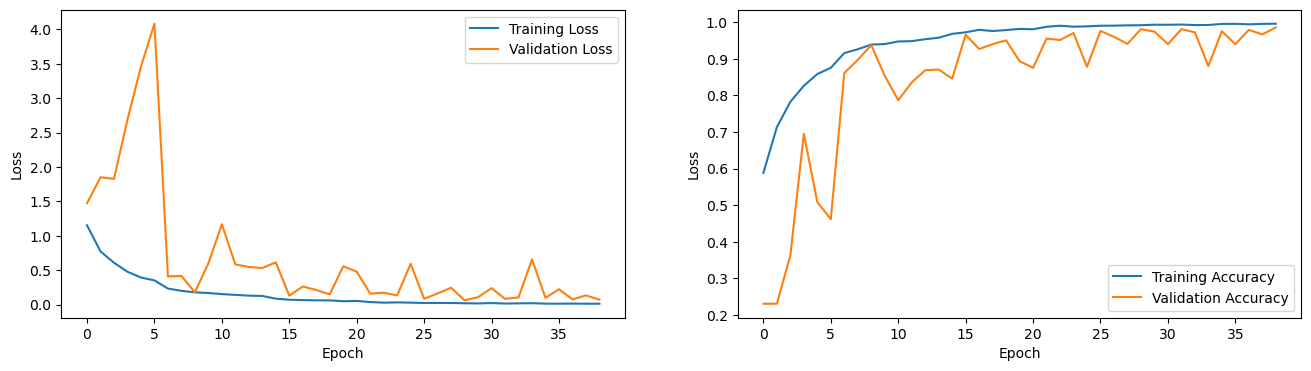

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

    
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Viendo los valores de nuestro modelo podemos observar como este con forme las epocas avanza, tiene un mejor desempeño, teniendo mayor accuracy y menor loss. De igual forma no podemos concluir que el modelo no se encuentra overfitteado con el dataset; ya que la perdida de validación va bajando de tal manera que se ajusta al modelo, pero no se ajusta tan perfecto que podamos pensar que tiene algún tipo de over o underfit.
Del lado derecho vemos como la accuracy incrementa de igual forma sin mostrar algun tipo de evidencia de under u overfit.
Por lo que vamos a realizar más pruebas para validar los resultados, creando una matriz de confusión.


Matriz de Confusión:
 [[236   2   4   2]
 [  1 299   0   0]
 [  3   3 235   7]
 [  2   0   0 263]]


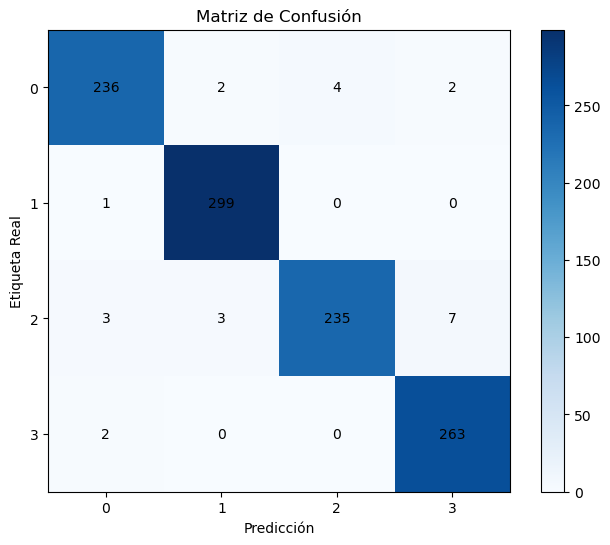

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Creamos la matriz de confusión con el numero de clases que tenemos en nuestro dataset y la inicializamos a 0
num_classes = 4  
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

#Para cada valor real y predicho, incrementamos el valor en la matriz de confusión.
for true_label, pred_label in zip(y_true, y_pred):
    confusion_matrix[true_label, pred_label] += 1

print("Matriz de Confusión:\n", confusion_matrix)

#Creamos una matriz de confusión usando matplotlib, con los datos que almacenamos previamente
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, cmap="Blues")
plt.colorbar()
plt.xticks(range(num_classes), range(num_classes))
plt.yticks(range(num_classes), range(num_classes))
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")

# Añadir anotaciones para cada celda
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")

plt.show()


Inicialmente definimos las clases como pituitary, meningioma, glioma, healthy, para interpretar la matriz de confusión podemos observar de arriba hacía abajo y de izquierda a derecha.

Nuestro modelo predice que de 244 instancias de pituitary, se clasificó de forma correcta 236 y 8 de manera erronea, donde pensaba que 4 eran healthy, teniendo en cuenta la importancia de que healthy sean clasificados de la manera más precisa, esto puede causar un problema enorme para la salud, ya que asume que 4 personas con meningiomas en realidad están saludables.

Siguiendo con las demás clases, Meningioma fue casi perfecto donde solo tuvo un error pensando que era Pituitary.

Con Glioma tenemos la mayor cantidad de errores, donde en 10 de los 245 casos nuestro modelo nota algun tipo de tumor distinto y en el peor de los casos cree que 7 personas tienen tumores benignos que en realidad son Gliomas.

Por último Healthy tenemos solamente 2 errores donde asume que es un Pituitary en lugar de Healthy, mientras que no es tan grave como con Glioma al tener falsos positivos, es para tener en cuenta la posibilidad de error.

Vamos a Mostrar un grid con varias imagenes que contengan imagenes de las clases, en conjunto con los valores predichos, con los valores reales.
De esta manera entender visualmente los resultados de nuestro modelo.

1/1 [==============================] - 0s 237ms/step


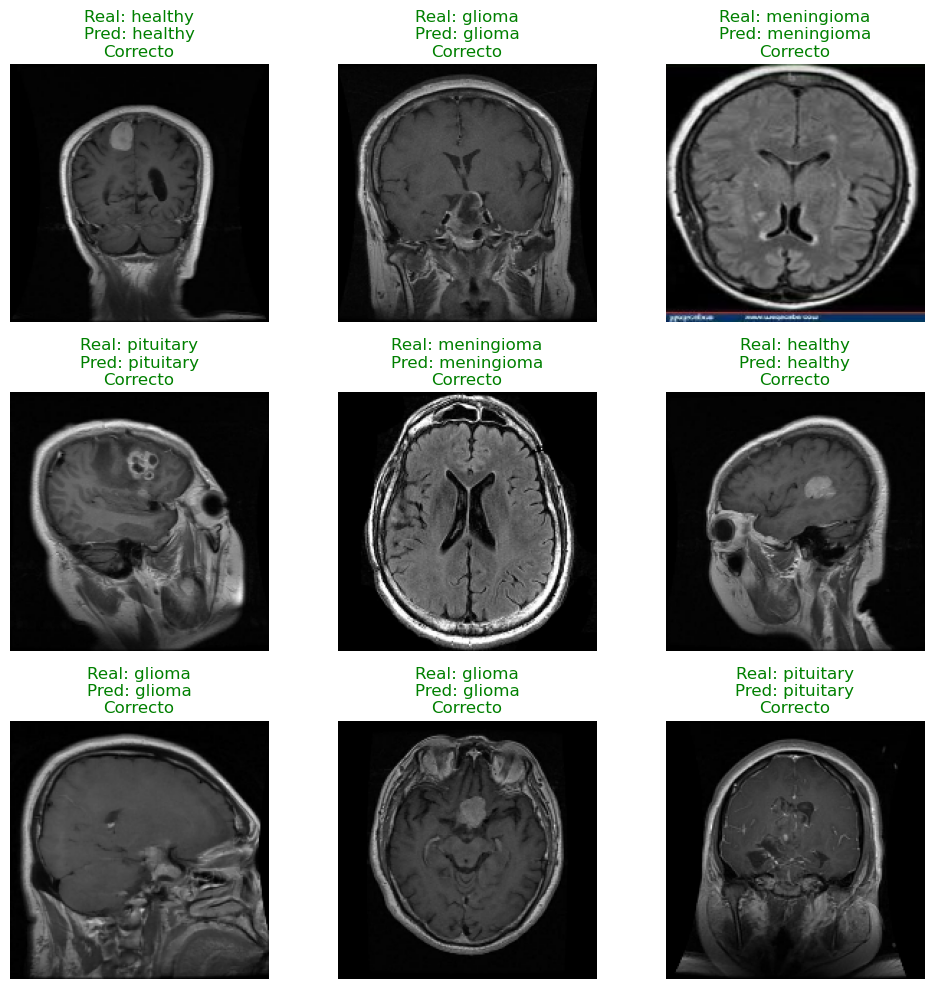

In [ ]:
class_names = {0: "Pituitary", 1: "Meningioma", 2: "Healthy", 3: "Glioma"}

#Creamos un lote de imágenes del conjunto de prueba, le realizamos las prediccioes y los guardamos en una clase
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)  
    predicted_labels = np.argmax(predictions, axis=1)  


#Mostramos las 9 imagenes y obtenemos las etiquetas de las clases reales y predichas
num_images = 9
images = images[:num_images]
labels = labels[:num_images]
predicted_labels = predicted_labels[:num_images]


#Realizamos el plot de las imágenes con las etiquetas reales y predichas
plt.figure(figsize=(10, 10))
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))  #Evita que las imagenes se muestren en formato float, las convierte a uint8
    
    #De cada etiqueta obtenemos el nombre de la clase
    true_label = labels[i].numpy()
    pred_label = predicted_labels[i]
    true_class_name = class_names[true_label]
    pred_class_name = class_names[pred_label]
    
    #Creamos la lógica de la etiqueta, donde cambiamos el color de la etiqueta si es correcta o incorrecta 
    #al igual que los titulos de las imagenes basandonos en esto
    is_correct = "Correcto" if true_label == pred_label else "Incorrecto"
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Real: {true_class_name}\nPred: {pred_class_name}\n{is_correct}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

Teniendo en cuenta los resultados mostrados usando el test set, como en el despliegue de imagenes, podemos determinar que el estado del modelo es optimo, y de alto valor, para mejoras a futuro notamos el tiempo de entrenamiento, que aunque no es el más alto, usando una combinación distinta de optimizadores podría realizar un mejor desempeño.

A continuación vamos a realizar una aplicación del modelo:

1/1 [==============================] - 1s 897ms/step


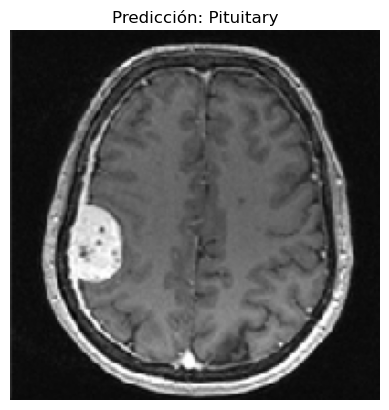

In [ ]:
#Rutas de modelo e imagen
img_path = "ejemplo_aplicacion.jpg"
model_path = "ModeloDL.keras"

#Cargar el modelo
model = load_model(model_path, custom_objects={'ResidualUnit': ResidualUnit})

# Cargar la imagen y preprocesarla
img = image.load_img(img_path, target_size=(180, 180))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión para el batch
img_array /= 255.0  # Escalar los valores de los píxeles

# Realizar la predicción
predictions = model.predict(img_array)
predicted_label = np.argmax(predictions, axis=1)[0]

# Obtener el nombre de la clase predicha
pred_class_name = class_names[predicted_label]

# Mostrar la imagen y la predicción
plt.imshow(img)
plt.title(f"Predicción: {pred_class_name}")
plt.axis("off")
plt.show()
